In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import numpy as np
from scipy import stats

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi']=300
plt.rcParams['pdf.fonttype']=42

In [2]:
import joblib
mt_pelatte = joblib.load('/home/qzeng/project/aging/231117_update_annot/AgingMajorType_Palette')

new_mt_palette = {}
for mt ,_color in mt_pelatte.items():
    mt= mt.replace('/','').replace(' ','_')
    new_mt_palette[mt] = _color

In [3]:
_gender = 'Male'
mc_type = 'CGN'

In [4]:
gene_name_to_id = joblib.load('/home/qzeng/project/aging/240112_DMG_CEF/gene_name_to_id_dict')
gene_id_to_name = joblib.load('/home/qzeng/project/aging/240112_DMG_CEF/gene_id_to_name_dict')

gene_meta_path = '/home/qzeng/project/aging/metadata/gencode.vM22.basic.annotation.gene.flat.tsv.gz'
gene_meta = pd.read_csv(gene_meta_path, index_col ='gene_id', sep='\t')
gene_meta['length'] = gene_meta['end'] - gene_meta['start']
gene_length_dict = gene_meta['length'].to_dict()

In [5]:
# _dir = '/home/qzeng/project/aging/240112_DMG_CEF'
# mc_all = pd.read_csv(f'{_dir}/dmg_result/{_gender}.{mc_type}.DMG.csv', index_col = 0)
# mc_all['celltype'] = mc_all['celltype'].apply(lambda x: x.replace('/','').replace(' ','_'))


_dir = '.'
mc_all = pd.read_csv(f'{_dir}/result/{_gender}.{mc_type}.AllGene.Anova.Result.csv', index_col = 0)
mc_all['celltype'] = mc_all['celltype'].apply(lambda x: x.replace('/','').replace(' ','_'))
mc_all.head()

/home/qz/miniconda3/envs/allcools/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,pvalue,corrected_pvalue,18mo,8wk,9mo,gene_length,celltype,methylation_change,abs_change,trend
genes,,,,,,,,,,
ENSMUSG00000052248.16,9.719166e-10,2.052585e-06,0.402388,0.297666,0.340218,3380,Astro-TE_NN,0.104722,0.104722,Aging Hyper
ENSMUSG00000041911.3,2.958576e-10,7.690093e-07,0.361111,0.259375,0.297317,5868,Astro-TE_NN,0.101735,0.101735,Aging Hyper
ENSMUSG00000001823.5,3.297061e-09,5.434571e-06,0.331053,0.246261,0.305954,2692,Astro-TE_NN,0.084792,0.084792,Aging Hyper
ENSMUSG00000043342.9,2.713778e-09,4.689175e-06,0.328699,0.238306,0.296553,2481,Astro-TE_NN,0.090393,0.090393,Aging Hyper
ENSMUSG00000037740.8,8.469976e-11,2.740242e-07,0.649030,0.548645,0.606800,4953,Astro-TE_NN,0.100386,0.100386,Aging Hyper


## select DEG

In [6]:
use_cts= joblib.load('mc_rna_corr_cts')
#use_cts = [ct for ct in use_cts if ct.endswith('NN') == False]

In [7]:
_type = 'DEG'
pvalue_cutoff = 0.05
fc_cutoff = 0.1

In [8]:
result = {}
deg_num = {}
for ct in use_cts:
    rna_df = pd.read_csv(f"DEGs/{ct}.csv", index_col = 0)
    rna_df['log2(Aged/Young)'] = -rna_df['avg_log2FC']
    deg_df = rna_df[(rna_df['p_val_adj'] < pvalue_cutoff) & (abs(rna_df['log2(Aged/Young)']) > fc_cutoff)]
    
    # get DEG mc info
    mc_df  = mc_all[mc_all['celltype'] == ct].copy()
    mc_df['gene_name'] = mc_df.index.map(gene_id_to_name)

    deg_mc_df = mc_df.set_index('gene_name')
    # select those is also DEG
    deg_mc_df = deg_mc_df.loc[deg_mc_df.index.isin(deg_df.index)]
    deg_mc_df['Aged-Young'] = deg_mc_df['18mo'] - deg_mc_df['8wk']
    
    
    # also filter for DMGs
    deg_mc_df  = deg_mc_df[deg_mc_df['pvalue'] < 0.05]
    
    # filter duplicate genes
    unique_genes = deg_mc_df.index.value_counts()[deg_mc_df.index.value_counts() == 1].index
    deg_df = deg_df.loc[unique_genes]
    deg_mc_df = deg_mc_df.loc[unique_genes]
    
    to_plot = pd.concat([deg_df[['log2(Aged/Young)']], deg_mc_df[['Aged-Young']]], axis = 1)
    to_plot = to_plot.dropna()
    deg_num[ct] = to_plot.shape[0]
    if to_plot.shape[0] >= 10:
        res = stats.pearsonr(to_plot['log2(Aged/Young)'], to_plot['Aged-Young'])
        result[ct] = res
    else:
        print(f"not enough {ct}")

not enough Lamp5_Gaba
not enough Vip_Gaba


In [9]:
deg_num = pd.DataFrame(deg_num.values(), index= deg_num.keys())
deg_num[0].sum()


17054

In [10]:
all_corr = pd.DataFrame(result).T
all_corr.columns = ['corr','pvalue']
all_corr = all_corr.sort_values('corr')
all_corr['celltype'] = all_corr.index

In [11]:
all_corr

,corr,pvalue,celltype
SUB-ProS_Glut,-0.815675,7.012407e-08,SUB-ProS_Glut
STR_D1_Sema5a_Gaba,-0.691915,4.564987e-211,STR_D1_Sema5a_Gaba
Sst_Gaba,-0.609721,8.754018e-06,Sst_Gaba
CEA-BST_Gaba,-0.595303,2.482227e-10,CEA-BST_Gaba
Oligo_NN,-0.438943,9.184132e-111,Oligo_NN
L6_CT_CTX_Glut,-0.426778,3.354793e-34,L6_CT_CTX_Glut
L6_IT_CTX_Glut,-0.415615,1.395214e-04,L6_IT_CTX_Glut
Astro-TE_NN,-0.411171,5.673847e-10,Astro-TE_NN
L23_IT_CTX_Glut,-0.355332,1.931103e-28,L23_IT_CTX_Glut
STR-PAL_Chst9_Gaba,-0.337866,2.851300e-12,STR-PAL_Chst9_Gaba


In [12]:
# order by class
glut_cts = []
gaba_cts = []
nn_cts = []
for ct in all_corr.index:
    if ct.endswith('Glut'):glut_cts.append(ct)
    elif ct.endswith('Gaba'):gaba_cts.append(ct)
    elif ct.endswith('NN'):nn_cts.append(ct)

new_order = nn_cts+ glut_cts + gaba_cts
all_corr = all_corr.loc[new_order]

In [13]:
mean_corr = round(all_corr['corr'].mean(),2)
mean_corr

-0.32

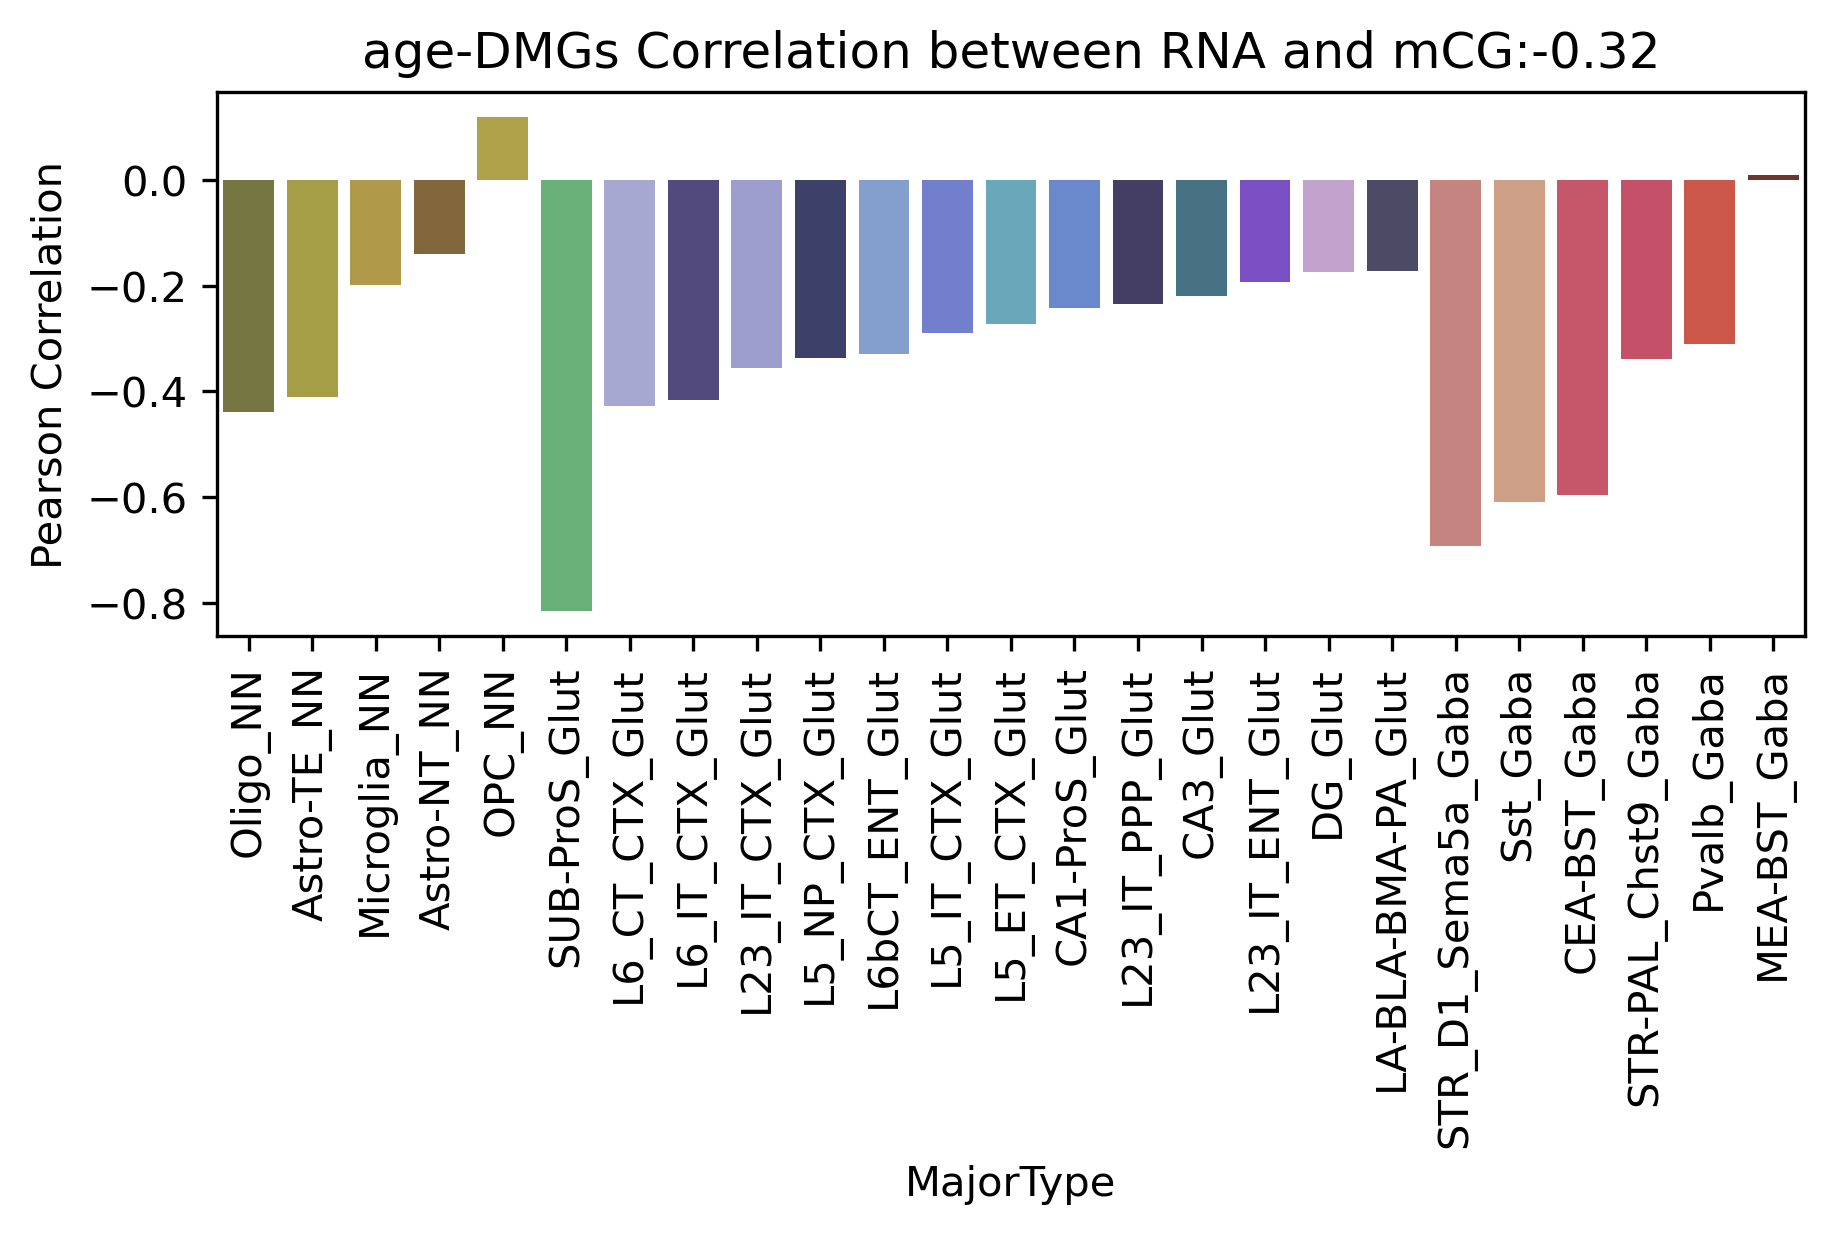

In [14]:
fig, ax =plt.subplots(figsize = (6,4), dpi = 300, constrained_layout = True)
sns.barplot(data = all_corr, 
            x="celltype", 
            y="corr", 
            hue="celltype", 
            palette = new_mt_palette,
            ax = ax,
            dodge=False,
            )

ax.legend_.remove()
#plt.legend(title='Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title(f'age-DMGs Correlation between RNA and mCG:{mean_corr}')
plt.xlabel('MajorType')
plt.ylabel('Pearson Correlation')
plt.xticks(rotation=90)
#ax.set_ylim(-0.9, 0.3)
#fig.savefig(f'{mc_type}.aDMG.RNA_mC.Corr.pdf', bbox_inches = 'tight')
plt.show()